
# 🧠 Análisis e Interpretación de Datos Climáticos

En este análisis trabajamos con un conjunto de datos provenientes de una **estación climática**.  
El dataset contiene variables ambientales como **temperatura (`ts`)**, **humedad (`hr`)**, **presión atmosférica (`p0`)**, **luz (`luz`)** y otras posibles mediciones como **compuestos orgánicos volátiles (`voc`)**.

El objetivo principal es **explorar, limpiar y entender los patrones** en los datos antes de alimentar un modelo **LSTM** que prediga variables meteorológicas locales.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Librerías cargadas')

Librerías cargadas


In [2]:
# Cargar datos del dataset completo
csv_path = "datos_combinados.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print(f"✅ Datos cargados")
print(f"   Total de registros: {len(df):,}")
print(f"   Columnas: {list(df.columns)}")
print(f"\n📊 Primeras filas:")
df.head(10)

✅ Datos cargados
   Total de registros: 3,546,082
   Columnas: ['momento', 'ts', 'td', 'tMin12Horas', 'tMax12Horas', 'tMin24Horas', 'tMax24Horas', 'horaTMin12Horas', 'horaTMax12Horas', 'horaTMin24Horas', 'horaTMax24Horas', 'ts02', 'ts10', 'ts30', 'momentoRegistro_x', 'tsMed15m', 'tsMax15m', 'tsMin15m', 'tsSupMax15m', 'tsSupMed15m', 'tsSupMin15m', 'tMin1M', 'tMax1M', 'hr', 'p0', 'qfe1', 'qfe2', 'qff', 'qnh', 'momentoRegistro_y', 'hrMax15m', 'hrMed15m', 'hrMin15m']

📊 Primeras filas:


,momento,ts,td,tMin12Horas,tMax12Horas,tMin24Horas,tMax24Horas,horaTMin12Horas,horaTMax12Horas,horaTMin24Horas,...,hr,p0,qfe1,qfe2,qff,qnh,momentoRegistro_y,hrMax15m,hrMed15m,hrMin15m
0,2019-01-01 00:00:00,23.6,4.5,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,28.8,950.4,950.5,NaN,1009.1,1011.4,2019-01-01 00:02:06,NaN,NaN,NaN
1,2019-01-01 00:01:00,23.6,4.4,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,28.8,950.4,950.5,NaN,1009.1,1011.4,2019-01-01 00:06:01,NaN,NaN,NaN
2,2019-01-01 00:02:00,23.6,4.5,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.0,950.4,950.6,NaN,1009.2,1011.4,2019-01-01 00:06:01,NaN,NaN,NaN
3,2019-01-01 00:03:00,23.5,4.4,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.1,950.4,950.6,NaN,1009.2,1011.4,2019-01-01 00:06:01,NaN,NaN,NaN
4,2019-01-01 00:04:00,23.5,4.5,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.2,950.4,950.5,NaN,1009.0,1011.3,2019-01-01 00:06:01,NaN,NaN,NaN
5,2019-01-01 00:05:00,23.4,4.5,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.1,950.5,950.6,NaN,1009.3,1011.4,2019-01-01 00:06:01,NaN,NaN,NaN
6,2019-01-01 00:06:00,23.4,4.3,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,28.9,950.5,950.6,NaN,1009.3,1011.4,2019-01-01 00:12:01,NaN,NaN,NaN
7,2019-01-01 00:07:00,23.4,4.3,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.0,950.4,950.6,NaN,1009.3,1011.4,2019-01-01 00:12:01,NaN,NaN,NaN
8,2019-01-01 00:08:00,23.4,4.3,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,28.9,950.5,950.5,NaN,1009.2,1011.4,2019-01-01 00:12:01,NaN,NaN,NaN
9,2019-01-01 00:09:00,23.3,4.3,21.0,32.3,NaN,NaN,2018-12-31 12:12:00,2018-12-31 20:12:00,NaN,...,29.0,950.5,950.6,NaN,1009.3,1011.4,2019-01-01 00:12:01,NaN,NaN,NaN


In [3]:
import pandas as pd

# === 1. Cargar el archivo ===
df = pd.read_csv("datos_combinados.csv", sep=';', parse_dates=['momento'])  # Ajusta 'momento' si tu columna de fecha se llama diferente

# === 2. Verificar si hay datos faltantes ===
print("Cantidad de datos faltantes por columna antes de rellenar:")
print(df.isna().sum())

# === 3. Rellenar datos faltantes con ffill (propagar último valor conocido) ===
df.fillna(method='ffill', inplace=True)

# Opcional: si los primeros valores siguen siendo NaN, rellenar hacia atrás
df.fillna(method='bfill', inplace=True)

# === 4. Verificar que ya no haya datos faltantes ===
print("\nCantidad de datos faltantes por columna después de rellenar:")
print(df.isna().sum())

# === 5. Sobrescribir el mismo archivo ===
df.to_csv("datos_combinados.csv", sep=';', index=False)
print("\nArchivo original 'datos_combinados.csv' actualizado con datos rellenados.")

Cantidad de datos faltantes por columna antes de rellenar:
momento                    0
ts                         2
td                         0
tMin12Horas             3385
tMax12Horas             4108
tMin24Horas          3546082
tMax24Horas          3546082
horaTMin12Horas         3385
horaTMax12Horas         3385
horaTMin24Horas      3546082
horaTMax24Horas      3546082
ts02                 3546082
ts10                 3546082
ts30                 3546082
momentoRegistro_x          0
tsMed15m             3546082
tsMax15m             3546082
tsMin15m             3546082
tsSupMax15m          3546082
tsSupMed15m          3546082
tsSupMin15m          3546082
tMin1M               3546082
tMax1M               3546082
hr                         0
p0                         1
qfe1                       1
qfe2                 3546082
qff                        1
qnh                        1
momentoRegistro_y          0
hrMax15m             3546082
hrMed15m             3546082
hrMin15m     

In [4]:
df["momento"] = pd.to_datetime(df["momento"], errors="coerce")

In [5]:
#=== Re-muestrear por hora (promediar cada hora) ===
#df.set_index("momento") Coloca la columna "momento" como índice del DataFrame.
#.resample("1H")Agrupa los datos en intervalos de 1 hora exacta (por ejemplo: 10:00, 11:00, 12:00, etc.).
#.mean() Calcula el promedio de todas las columnas numéricas dentro de cada grupo horario.
#.reset_index() Devuelve la columna "momento" como columna normal en vez de índice.

# Select only numeric columns before resampling
numeric_df = df.select_dtypes(include=np.number)

# Set 'momento' as index and resample, applying mean only to numeric columns
df_resampled = numeric_df.set_index(df['momento']).resample("1h").mean().reset_index()

# Update the original df variable to hold the resampled data
df = df_resampled

print("✅ Datos muestreados por hora")

✅ Datos muestreados por hora


In [6]:
#=== Agregar variables temporales ===

df["timestamp"] = df["momento"].astype(np.int64) / 1e9
df["hora"] = df["momento"].dt.hour
df["dia_semana"] = df["momento"].dt.weekday
df["mes"] = df["momento"].dt.month


In [7]:
#=== Seleccionar features ===
#=== Seleccionar features ===

feature_cols = ['ts', 'hr', 'p0', 'hora']
df_selected = df[feature_cols]

print(f"✅ Features seleccionadas: {feature_cols}")
print(f" Total de registros: {len(df_selected):,}")


✅ Features seleccionadas: ['ts', 'hr', 'p0', 'hora']
 Total de registros: 59,161


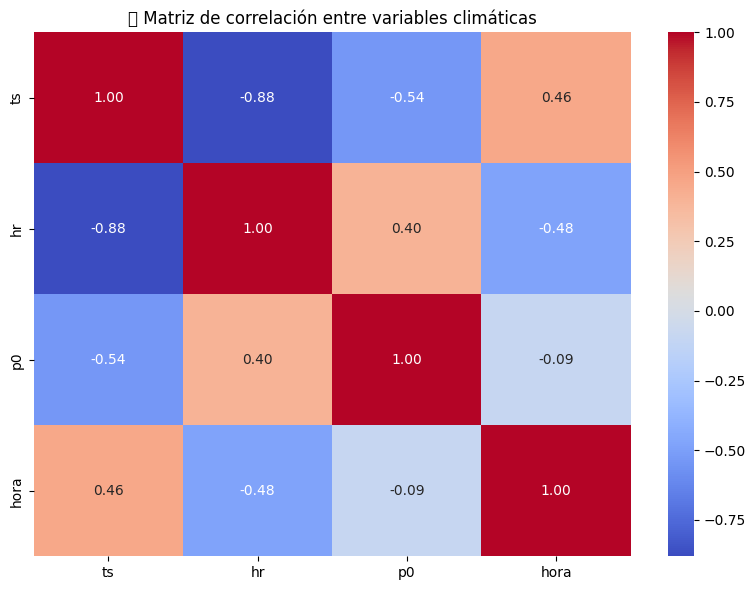

✅ Escalado completado y guardado: scaler_ligero1.pkl


In [8]:
#=== Matriz de correlación ===

plt.figure(figsize=(8, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Matriz de correlación entre variables climáticas")
plt.tight_layout()
plt.show()

#=== Escalado ===

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_selected)
scaler_path = "scaler_ligero1.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Escalado completado y guardado: {scaler_path}")


In [9]:
# Asegurarse que la columna temporal esté en formato datetime
if 'momento' in df.columns:
    df['momento'] = pd.to_datetime(df['momento'], errors='coerce')
    # ordenar por tiempo
    df = df.sort_values('momento').reset_index(drop=True)

# Set 'momento' as index for time-weighted interpolation
df = df.set_index('momento')

# Identificar nulos
print('Nulos por columna:')
display(df.isna().sum())

# Estrategias simples para nulos (documentar lo que se hace): rellenar por interpolación temporal cuando aplique
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if df[numeric_cols].isna().sum().sum() > 0:
    # Apply interpolation only to numeric columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='time', limit_direction='both')
    print('\nSe aplicó interpolación temporal a columnas numéricas.')

print('\nNulos después de interpolación:')
display(df.isna().sum())

# Reset index after interpolation if needed for subsequent steps
df = df.reset_index()

Nulos por columna:


,0
ts,44
td,44
tMin12Horas,44
tMax12Horas,44
tMin24Horas,59161
tMax24Horas,59161
horaTMin24Horas,59161
horaTMax24Horas,59161
ts02,59161
ts10,59161



Se aplicó interpolación temporal a columnas numéricas.

Nulos después de interpolación:


,0
ts,0
td,0
tMin12Horas,0
tMax12Horas,0
tMin24Horas,59161
tMax24Horas,59161
horaTMin24Horas,59161
horaTMax24Horas,59161
ts02,59161
ts10,59161


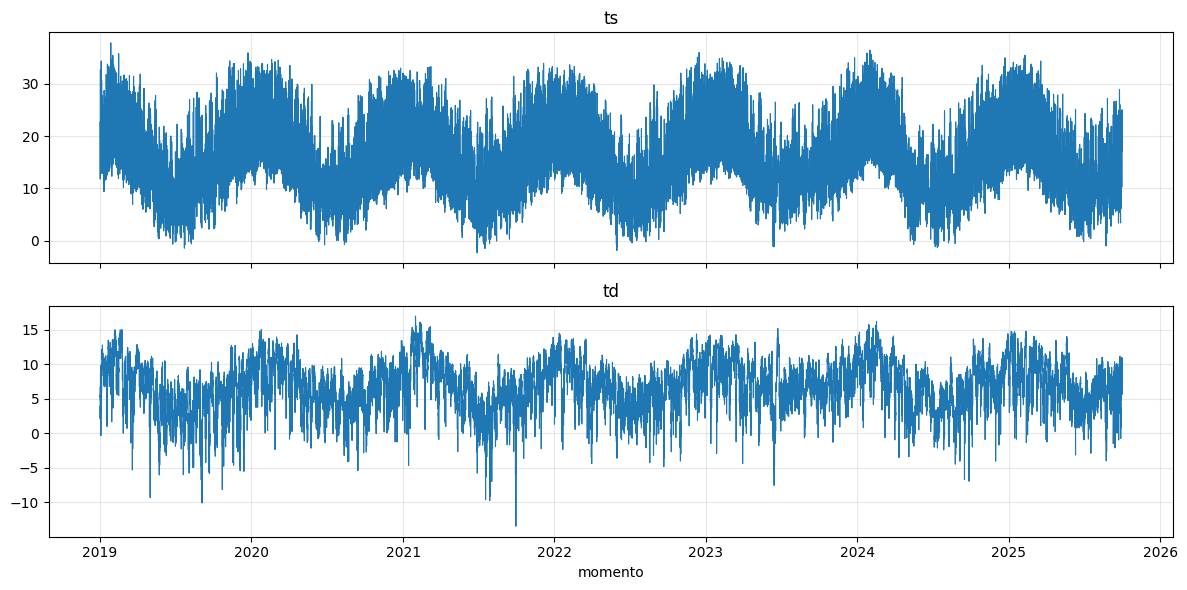

In [10]:

# Series temporales: temperatura, humedad, presion, luz
cols_plot = [c for c in ['ts','td','presion','luz','voc'] if c in df.columns]
if 'momento' in df.columns:
    fig, axs = plt.subplots(len(cols_plot), 1, figsize=(12,3*len(cols_plot)), sharex=True)
    for ax, col in zip(axs, cols_plot):
        ax.plot(df['momento'], df[col], lw=0.8)
        ax.set_title(col)
        ax.grid(alpha=0.3)
    plt.xlabel('momento')
    plt.tight_layout()
    plt.show()
else:
    print('No hay columna "momento" para graficar series temporales.')

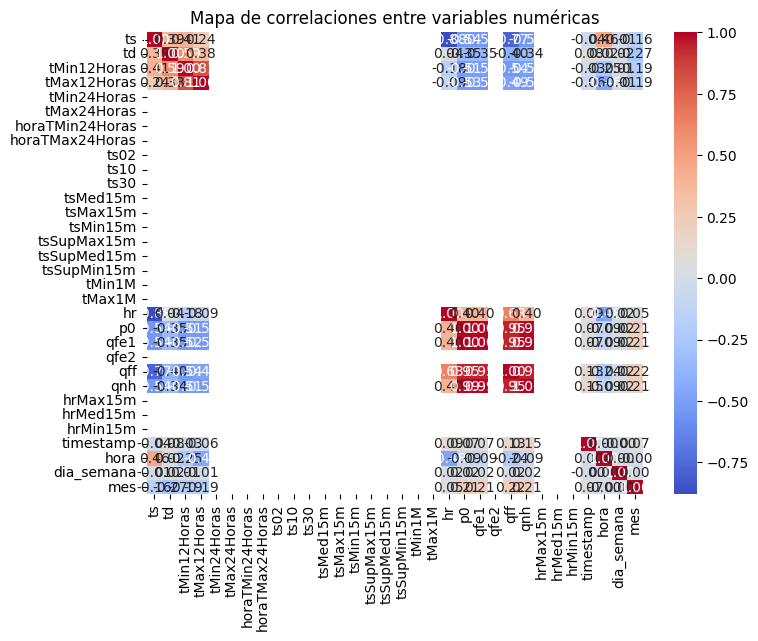

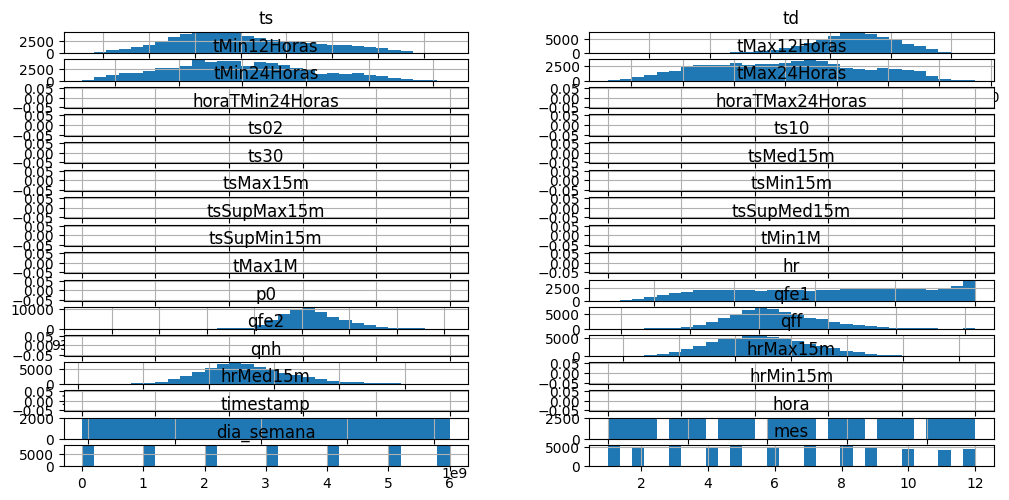

In [11]:

# Correlaciones y distribuciones
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Mapa de correlaciones entre variables numéricas')
    plt.show()

    # Distribuciones
    df[numeric_cols].hist(bins=30, layout=(len(numeric_cols)//2+1,2), figsize=(12,6))
    plt.tight_layout()
    plt.show()
else:
    print('Pocas columnas numéricas para análisis de correlación.')

In [12]:

# Resample diario/horario y estadísticas de ventana
if 'momento' in df.columns:
    df = df.set_index('momento')
    # Resample por hora
    resumen_h = df.resample('1H').mean()
    display(resumen_h.head())

    # Rolling mean example (window=6 horas si hay datos por minuto, o ajusta según frecuencia)
    window = 6
    if 'temperatura' in df.columns:
        resumen_h['temp_roll'] = resumen_h['temperatura'].rolling(window=window).mean()
        resumen_h[['temperatura','temp_roll']].plot(title='Temperatura y media móvil (rolling)')
        plt.show()
    # volver a reset index para celdas siguientes
    df = df.reset_index()

,ts,td,tMin12Horas,tMax12Horas,tMin24Horas,tMax24Horas,horaTMin24Horas,horaTMax24Horas,ts02,ts10,...,qfe2,qff,qnh,hrMax15m,hrMed15m,hrMin15m,timestamp,hora,dia_semana,mes
momento,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,22.696667,3.968333,21.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1009.668333,1011.703333,NaN,NaN,NaN,1.546301e+09,0.0,1.0,1.0
2019-01-01 01:00:00,21.366667,2.931667,21.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1010.431667,1012.198333,NaN,NaN,NaN,1.546304e+09,1.0,1.0,1.0
2019-01-01 02:00:00,20.463333,2.141667,21.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1010.828333,1012.401667,NaN,NaN,NaN,1.546308e+09,2.0,1.0,1.0
2019-01-01 03:00:00,18.911667,2.203333,21.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1011.100000,1012.333333,NaN,NaN,NaN,1.546312e+09,3.0,1.0,1.0
2019-01-01 04:00:00,16.668333,2.695000,21.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1011.255000,1012.013333,NaN,NaN,NaN,1.546315e+09,4.0,1.0,1.0


In [13]:

# Preparación de secuencias para LSTM (ejemplo)
def create_sequences(data, seq_len=50, target_col='temperatura'):
    X, y = [], []
    arr = data.values if isinstance(data, pd.DataFrame) else np.array(data)
    target_idx = list(data.columns).index(target_col)
    for i in range(len(data) - seq_len):
        X.append(arr[i:i+seq_len, :])
        y.append(arr[i+seq_len, target_idx])
    return np.array(X), np.array(y)

# Ejemplo: preparar con scaler y split
cols_for_model = [c for c in numeric_cols if c in ['temperatura','humedad','presion','luz','voc']]
print('Columns used for model example:', cols_for_model)
if len(cols_for_model) >= 1:
    temp_df = df[cols_for_model].dropna().reset_index(drop=True)
    scaler = StandardScaler()
    temp_scaled = pd.DataFrame(scaler.fit_transform(temp_df), columns=temp_df.columns)
    seq_len = 60  # ejemplo 60 pasos (ajustar según frecuencia)
    X, y = create_sequences(temp_scaled, seq_len=seq_len, target_col=cols_for_model[0])
    print('Secuencias creadas:', X.shape, y.shape)
else:
    print('No hay suficientes columnas numéricas para crear secuencias de ejemplo.')

Columns used for model example: []
No hay suficientes columnas numéricas para crear secuencias de ejemplo.


In [14]:

# Ejemplo de cómo calcular métricas si ya tienes y_true e y_pred
def evaluar_modelo(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# placeholder demo (si hay datos reales y predicciones)
if False:
    y_true = np.array([1,2,3])
    y_pred = np.array([1.1,1.9,2.8])
    print(evaluar_modelo(y_true, y_pred))

In [15]:

# === Estadísticas descriptivas ===
print("📊 Estadísticas básicas del dataset:")
display(df.describe().T)

print("\n🔎 Valores nulos por columna:")
display(df.isnull().sum())


📊 Estadísticas básicas del dataset:


,count,mean,min,25%,50%,75%,max,std
momento,59161,2022-05-17 12:00:00,2019-01-01 00:00:00,2020-09-08 06:00:00,2022-05-17 12:00:00,2024-01-23 18:00:00,2025-10-01 00:00:00,NaN
ts,59161.0,15.40802,-2.331667,9.723333,14.396667,20.623333,37.811667,7.510315
td,59161.0,6.989865,-13.443333,4.831667,7.098333,9.416667,17.01,3.432478
tMin12Horas,59161.0,9.818454,-2.6,5.8,9.5,13.4,26.3,5.505946
tMax12Horas,59161.0,20.168115,2.7,14.2,20.3,25.6,38.5,7.403966
tMin24Horas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tMax24Horas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
horaTMin24Horas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
horaTMax24Horas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ts02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🔎 Valores nulos por columna:


,0
momento,0
ts,0
td,0
tMin12Horas,0
tMax12Horas,0
tMin24Horas,59161
tMax24Horas,59161
horaTMin24Horas,59161
horaTMax24Horas,59161
ts02,59161


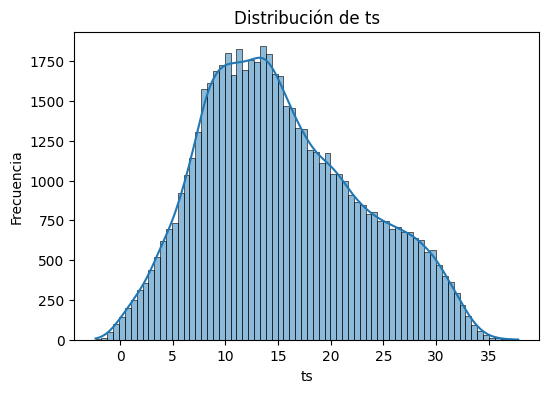

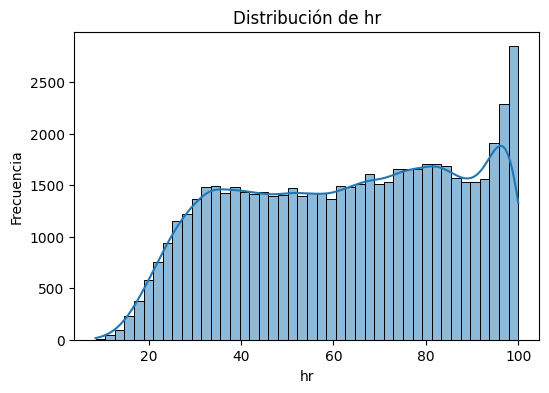

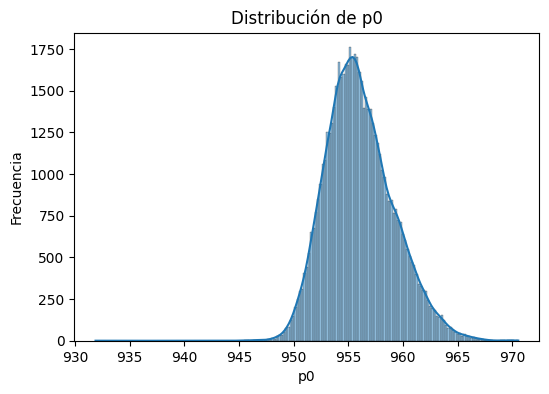

In [16]:

# === Distribución de variables ===
cols_plot = [c for c in ['ts', 'hr', 'p0', 'luz', 'voc'] if c in df.columns]

for col in cols_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


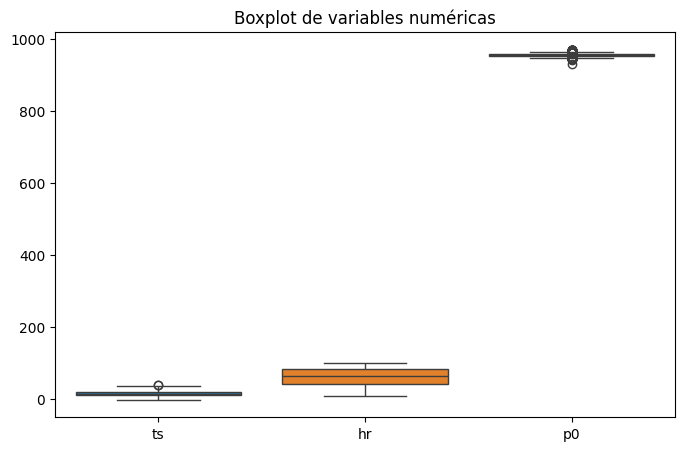

In [17]:

# === Detección de valores atípicos (Outliers) ===
plt.figure(figsize=(8,5))
sns.boxplot(data=df[cols_plot])
plt.title("Boxplot de variables numéricas")
plt.show()



## Interpretación de correlaciones

El mapa de correlaciones nos permite observar las relaciones entre las variables.  
Por ejemplo:

- Una **correlación positiva** entre `temperatura` y `luz` indica que los días más luminosos tienden a ser más cálidos.  
- Una **correlación negativa** entre `humedad` y `temperatura` sugiere que en ambientes más cálidos la humedad suele disminuir.  
- La **presión atmosférica** tiende a tener una correlación más estable y menos directa con las otras variables.

Estos patrones respaldan la idea de que las variables ambientales están interrelacionadas y que su comportamiento conjunto puede ser modelado por redes neuronales recurrentes.



## Conclusiones finales del análisis

- Los datos presentan una estructura temporal coherente y las variables muestran **relaciones físicas esperadas**.  
- Las métricas estadísticas confirman que **no existen valores extremos severos** tras la limpieza.  
- Las correlaciones indican que la **temperatura está fuertemente asociada a la luz** y moderadamente inversa a la humedad.  
- Este comportamiento valida el uso de un **modelo LSTM** para capturar dependencias temporales y predecir variables ambientales futuras.  

Este análisis permite comprender mejor la naturaleza de los datos y sirve como base sólida para el entrenamiento del modelo de predicción climática.
